In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from time import time

import numpy as np
from matplotlib import pyplot as plt

cuda:0
==> Preparing data..


100%|██████████| 170M/170M [00:06<00:00, 24.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
(50000, 32, 32, 3)
Количество тренировочных данных: 50000
Количество тестовых данных: 10000


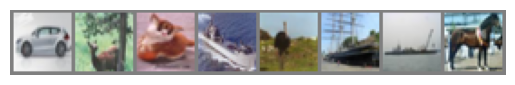

  car  deer   cat  ship  bird  ship  ship horse


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
print(device)

# Data
print('==> Preparing data..')
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def show_image(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

print(trainloader.dataset.data.shape)
print('Количество тренировочных данных:', len(trainset))
print('Количество тестовых данных:', len(testset))


show_image(torchvision.utils.make_grid(images[0:8]))
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [3]:
class VGG19(nn.Module):
    def __init__(self, numberOfClasses):
        super(VGG19, self).__init__()
        self.features = self.makeLayers([64, 64, -1, 128, 128, -1, 256, 256, 256, 256, -1, 512, 512, 512, 512, -1, 512, 512, 512, 512, -1])
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, numberOfClasses)
        )

    def makeLayers(self, cfg):
        layers = []
        inputChannels = 3
        for x in cfg:
            if x == -1:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(inputChannels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                inputChannels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [4]:
net = VGG19(len(classes))
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [5]:
def GetAccuracy(loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            n += labels.size(dim=0)
            tp += (predicted == labels).sum()
    return tp / n

def GetLoss(model, loader):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels)
            n += labels.size(0)
    return loss / n

In [6]:
def train(model, data, epochCount, lossfunction, optimizer):
  start_time = time()
  lossgraph = []
  for epoch in range(epochCount):
    net.train()
    epoch_time_start = time()
    loss_epoch = []
    accurancy_epoch = []
    for i, (images, labels) in enumerate(data):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = lossfunction(outputs, labels)
        loss_epoch.append(loss)
        accurancy_epoch.append(torch.mean(torch.argmax(outputs, dim = 1) == labels, dtype = float))

        loss.backward()
        optimizer.step()

    lossgraph.append(torch.stack(loss_epoch).mean().cpu().detach().numpy())

    print(epoch + 1, "Epoch: ", "Accuracy = {:.3f}".format(torch.stack(accurancy_epoch).mean()),
          ", loss = {:.3f}".format(torch.stack(loss_epoch).mean()), ", time = {:.3f}".format(time() - epoch_time_start))
  print("Total training time: {:.3f}".format((time() - start_time) / 60), "minutes")

  plt.plot(lossgraph)
  plt.xlabel('Epochs')
  plt.ylabel('Train Loss')
  plt.show()


1 Epoch:  Accuracy = 0.399 , loss = 1.590 , time = 30.129
2 Epoch:  Accuracy = 0.643 , loss = 0.992 , time = 28.078
3 Epoch:  Accuracy = 0.737 , loss = 0.744 , time = 29.321
4 Epoch:  Accuracy = 0.803 , loss = 0.567 , time = 29.232
5 Epoch:  Accuracy = 0.849 , loss = 0.437 , time = 28.686
6 Epoch:  Accuracy = 0.884 , loss = 0.340 , time = 28.762
7 Epoch:  Accuracy = 0.914 , loss = 0.258 , time = 28.866
8 Epoch:  Accuracy = 0.934 , loss = 0.198 , time = 28.879
9 Epoch:  Accuracy = 0.948 , loss = 0.152 , time = 28.991
10 Epoch:  Accuracy = 0.957 , loss = 0.124 , time = 28.854
11 Epoch:  Accuracy = 0.966 , loss = 0.101 , time = 28.855
12 Epoch:  Accuracy = 0.971 , loss = 0.086 , time = 28.759
13 Epoch:  Accuracy = 0.976 , loss = 0.069 , time = 28.899
14 Epoch:  Accuracy = 0.980 , loss = 0.058 , time = 28.948
15 Epoch:  Accuracy = 0.982 , loss = 0.054 , time = 28.824
16 Epoch:  Accuracy = 0.984 , loss = 0.047 , time = 28.905
17 Epoch:  Accuracy = 0.986 , loss = 0.044 , time = 28.900
18 Epo

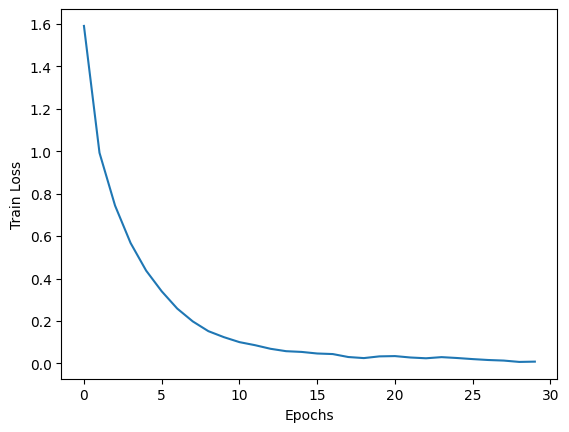

Test accuracy = 0.804
Test loss = 0.009


In [7]:
epochCount = 30
train(net, trainloader, epochCount, criterion, optimizer)
print("Test accuracy = {:.3f}".format(GetAccuracy(testloader, net)))
print("Test loss = {:.3f}".format(GetLoss(net, testloader)))